In [7]:
import numpy as np
import networkx as nx
from networkx import grid_graph
from scipy import linalg
from scipy.special import sici
import math
from matplotlib import pyplot as plt

# Poulson Algorithm 1

In [8]:
def sampling_algorithm_1(K):
    
    n = len(K)
    
    sample = []
    A = K.copy()

    for j in range(n):

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

    return sample, A


# Scaled Sine Kernel Projection

10.000000000000005


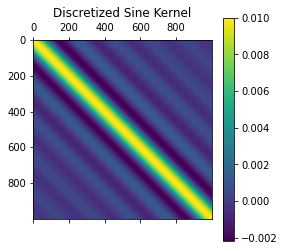

11


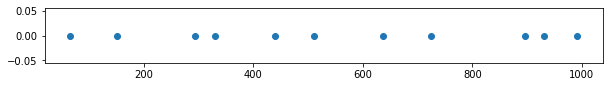

In [9]:
n = 1000

def Si(x):
    try: 
        upper = sici(x)[0]
    except:
        upper = sici(x)
    return upper
        
def integral_Si(x):
    return math.cos(x) + x*Si(x)

def compute_sine_kernel_entry(a,b,c,d):
    return (integral_Si(math.pi*(c-b))-integral_Si(math.pi*(c-a)) - (integral_Si(math.pi*(d-b))- integral_Si(math.pi*(d-a))))/((math.pi**2)*(b-a)*(d-c))

r =[-5,5]
slice_size = (max(r)-min(r))/n

# determine # of slices
n_slices = int((max(r)-min(r))/slice_size +1)

# split the range
x_part = np.linspace(*r, n_slices)
y_part = np.linspace(*r, n_slices)

kernel = np.array([[compute_sine_kernel_entry(x_part[i],x_part[i+1],y_part[j],y_part[j+1]) for i in range(len(x_part)-1)] for j in range(len(y_part)-1)])
kernel = (max(r)-min(r))/np.trace(kernel) * kernel

print(np.trace(kernel))

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

samples,_ = sampling_algorithm_1(np.array(kernel))
fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(len(samples))


 # Scaled Sine Kernel Projection

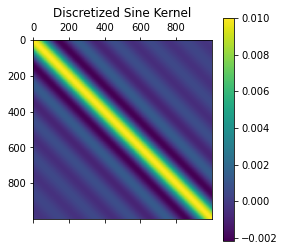

10


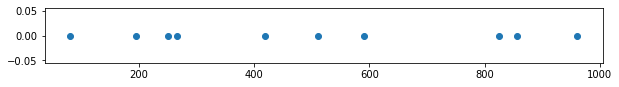

In [116]:
n = 1000
a=0
b=10

bins = n-1

def sinx_x(m):
    m[m != 0] = np.sin(math.pi*m[m != 0])/(math.pi*m[m != 0])
    m[m==0] = 1
    return m 

partitions = np.linspace(a, b, num=n)

random_vect = np.array([np.random.uniform(partitions[i], partitions[i+1]) for i in range(len(partitions)-1)])
random_vect = np.repeat(random_vect, bins).reshape(bins,bins)

kernel = sinx_x(random_vect-random_vect.T)
kernel = (b-a)/np.trace(kernel) * kernel

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

samples,_ = sampling_algorithm_1(np.array(kernel))
fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(len(samples))

 # Gaussian Kernel in R^2


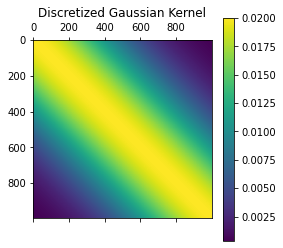

5


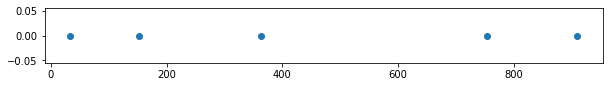

In [136]:
n = 1000
a=-1
b=1
intensity = 10 

bins = n-1

def gaussian_kernel(m):
    return np.exp(-(np.power(m,2)))

partitions = np.linspace(a, b, num=n)

random_vect = np.array([np.random.uniform(partitions[i], partitions[i+1]) for i in range(len(partitions)-1)])
random_vect = np.repeat(random_vect, bins).reshape(bins,bins)

kernel = gaussian_kernel(random_vect-random_vect.T)
kernel = intensity*(b-a)/np.trace(kernel) * kernel

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Gaussian Kernel")
plt.show()

samples,_ = sampling_algorithm_1(np.array(kernel))
fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(len(samples))

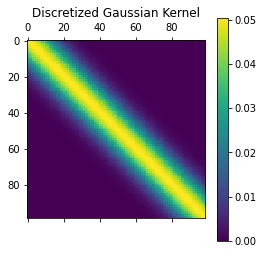

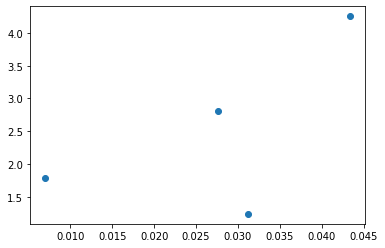

In [263]:
bins_horizontal = 100
n = bins_horizontal * bins_horizontal
intensity = 5
a=0
b=5

partitions = np.linspace(a, b, num=bins_horizontal)

def gaussian_kernel_grid(m):
    return np.exp(-(np.power(m[:,:,0],2) + np.power(m[:,:,1],2)))

random_vect = np.array([[np.random.uniform(partitions[i], partitions[i+1]),
                         np.random.uniform(partitions[j], partitions[j+1]) ]
                       for i in range(len(partitions)-1) for j in range(len(partitions)-1)                        
                       ]
                      ).reshape(bins_horizontal-1,bins_horizontal-1,2)


kernel = gaussian_kernel_grid(random_vect-random_vect.transpose((1,0,2)))
kernel = (b-a)/np.trace(kernel) * kernel


plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Gaussian Kernel")
plt.show()

samples,_ = sampling_algorithm_1(np.array(kernel))


output = np.zeros(bins_horizontal)
output[samples] = 1

random_vect = np.array([[np.random.uniform(partitions[i], partitions[i+1]),
                         np.random.uniform(partitions[j], partitions[j+1]) ]
                       for i in range(bins_horizontal-1) for j in range(bins_horizontal-1)                        
                       ]
                      )


plt.scatter(random_vect[samples].T[0], random_vect[samples].T[1])
